## Australian Census Demographic Analysis (2016–2021)

### Bhavya Narula

# Australian Census Demographic Analysis (2016–2021)

## Executive Summary

This project analyses demographic shifts in Australia between the 2016 and 2021 Census using harmonised ABS DataPacks. After standardising 190+ ancestry variables across years, growth rate analysis identified significant expansion in Indian, Chinese, and Filipino ancestry groups, alongside increases in overseas-parent households. Findings highlight migration-driven structural changes with implications for workforce composition, urban planning, and service demand.

# Introduction

Australia is renowned as one of the world's most culturally diverse countries, and migration has had a significant impact on its society. People from all over the world have made Australia their home, and this cultural mix has shaped not only the country's population, but also its workforce, traditions, and global ties. This diversity is frequently viewed as an asset since it introduces new talents, languages, and viewpoints that can help Australia compete on a global scale. At the same time, migration and ancestry remain hot themes in public debates. Recently, there has been concern about immigrants putting a strain on housing and jobs, making it even more crucial to consider actual evidence rather than just opinions.

The Census, conducted by the Australian Bureau of Statistics (ABS), is the most credible dataset for this. It records not just where people were born, but also their ancestry, allowing for a more complete picture of cultural identity and history. By comparing Census data from 2016 and 2021, we can examine how ancestry groups have changed over time and what this means for Australia's cultural diversity.

 I chose to focus on ancestry and migration since I'm curious about how different ethnic groups are increasing or changing in Australia. I'm curious if newer migrant groups are becoming more significant in the general population than more established ancestries, such as English or Irish. This comparison can help us understand how migration is influencing modern Australia and where the country may be headed in terms of diversity. That’s why my research question is: **How have ancestry patterns in Australia changed from 2016 to 2021 and what does this tell us about the role of migration in shaping cultural diversity?**

# Data Sources and Harmonisation

## Data Source

Demographic data was sourced from the Australian Bureau of Statistics (ABS) Census DataPacks for 2016 and 2021, specifically the General Community Profile (GCP) for Australia. The analysis focuses on Table G08 (Ancestry by Country of Birth of Parents), which contains national-level ancestry counts.

---

## Raw Data Structure

The G08 table is provided in wide format, where:

- A single row represents the total Australian population  
- Approximately 190 columns represent ancestry groups  
- Parental background categories are embedded within column headers  
- Total response counts are included alongside ancestry categories  

This structure required transformation before meaningful cross-year comparison could be performed.

---

## Data Harmonisation Approach

To enable accurate comparison between 2016 and 2021 datasets, the following steps were undertaken:

- Removal of metadata rows and non-numeric entries  
- Conversion of population counts to numeric format  
- Standardisation and alignment of ancestry categories across years  
- Reshaping of tables into tidy format for structured analysis  

This harmonisation ensured that observed demographic differences reflected genuine population shifts rather than structural inconsistencies in the source files.

---

## Methodological Considerations

Ancestry in the ABS Census is self-identified, and individuals may report up to two ancestries. Consequently, changes over time may reflect both demographic shifts and evolving identity patterns. Despite this limitation, Census data provides the most comprehensive national overview of ancestry trends in Australia.


# Data Cleaning


The raw Census G08 data we collected was not immediately ready for analysis, so I performed a series of cleaning processes to make sure it was accurate and reliable.   The main steps were:

- **Import and first inspection**: Loaded the CSV files for 2016 and 2021 and compared their structure to the metadata to ensure alignment.
- **Removal of whitespaces**: Any unwanted spaces within the text were removed so that the values matched correctly.
- **Type conversion**: Columns that seemed numeric but were kept as text were transformed to numerical values, allowing for precise calculations.
- **Column selection**: Emphasised solely on ancestral-related data and eliminated totals and not stated categories because they provide no helpful information.
- **Column renaming**: Lengthy, complex names were condensed into more concise and readable labels (for example, english_tot_resp became English).
- **Consistency check**: Check for consistency: Ensured that both years had the same ancestry categories and eliminated duplicates or insignificant data.

Following these processes, the cleaned G08 dataset became structured and easy to use, making it simple to develop new dataframes (such as the ancestry comparison and parents) and generate visualisations for the two Census years.


In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

Importing the standard Python libraries for data analysis and visualisation. These provide the basic tools for cleaning, processing, and plotting the Census data.

In [2]:
#  Load the two AUS G08 files (2016 and 2021)

f16 = "2016Census_G08_AUS.csv"
f21 = "2021Census_G08_AUS_AUS.csv"

g08_16 = pd.read_csv(f16)
g08_21 = pd.read_csv(f21)

The two CSV files containing ancestry data from the ABS Census DataPacks are imported into pandas DataFrames. Table G08 was chosen because it contains precise information regarding ancestry, such as whether parents were born in Australia or elsewhere. We load the 2016 and 2021 datasets for comparison.

In [3]:


def load_and_clean_g08(path_2016, path_2021):
    """
    Reads the two AUS G08 CSVs, cleans, and renames columns into nice labels.
    Returns df16, df21.
    """
    # Load raw
    df16_raw = pd.read_csv(path_2016)
    df21_raw = pd.read_csv(path_2021)

    # Copy
    df16, df21 = df16_raw.copy(), df21_raw.copy()

    # Standardise column names (lowercase, underscores)
    def standardise_cols(df):
        df.columns = (
            df.columns.str.strip()
            .str.lower()
            .str.replace(r"[^a-z0-9]+", "_", regex=True)
        )
        return df

    df16 = standardise_cols(df16)
    df21 = standardise_cols(df21)

    # Strip whitespace in object columns
    for df in [df16, df21]:
        str_cols = df.select_dtypes(include="object").columns
        df[str_cols] = df[str_cols].map(lambda x: x.strip() if isinstance(x, str) else x)

    # Convert numerics
    for df in [df16, df21]:
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        df.fillna(0, inplace=True)

    # Keep only shared columns
    shared_cols = list(set(df16.columns) & set(df21.columns))
    df16 = df16[["aus_code_2016"] + shared_cols].copy()
    df21 = df21[["aus_code_2021"] + shared_cols].copy()

    df16.rename(columns={"aus_code_2016": "geo_code"}, inplace=True)
    df21.rename(columns={"aus_code_2021": "geo_code"}, inplace=True)

    # Renaming into more readable names
    def pretty_label(col):
        if col == "geo_code":
            return "geo_code"

        # Handle ancestry totals
        if col.endswith("_tot_resp"):
            base = col.replace("_tot_resp", "")
            return base.title()

        # Handle parental birthplace codes
        label = col
        label = label.replace("bp_b_aus", "(Both Parents AUS)")
        label = label.replace("bp_b_os", "(Both Parents Overseas)")
        label = label.replace("fo_b_os", "Father Overseas-born")
        label = label.replace("mo_b_os", "Mother Overseas-born")
        label = label.replace("bp_ns", "(Birthplace Not Stated)")
        label = label.replace("ancestry_ns", "Ancestry Not Stated")
        label = label.replace("aust_abor", "Aboriginal")

        # Title-case everything else
        label = re.sub("_+", " ", label).title()
        return label

    df16.rename(columns={c: pretty_label(c) for c in df16.columns}, inplace=True)
    df21.rename(columns={c: pretty_label(c) for c in df21.columns}, inplace=True)

    return df16, df21
# Calling it 
df16, df21 = load_and_clean_g08("2016Census_G08_AUS.csv", "2021Census_G08_AUS_AUS.csv")



This function reads the raw Census G08 files for 2016 and 2021 and cleans them so they are ready for use. It simplifies column names, removes spaces, converts numerical values, fills in missing data, and retains those columns that are present in both files. Finally, it renames the columns with more readable labels and delivers two cleaned DataFrames (df16 and df21).

In [4]:
# --- Exact column names from your cleaned G08 files ---
TOT_COL         = "Tot_P"
BOTH_AUS_COL    = "Tot P (Both Parents Aus)"
BOTH_OS_COL     = "Tot P (Both Parents Overseas)"
FATHER_OS_COL   = "Tot P Father Overseas-Born"
MOTHER_OS_COL   = "Tot P Mother Overseas-Born"



# --- Build a tidy parents table (counts) ---
parents = pd.DataFrame({
    "Parental birthplace": [
        "Both parents AUS",
        "Both parents overseas",
        "Father overseas-born",
        "Mother overseas-born",
    ],
    "2016": [
        int(df16.loc[0, BOTH_AUS_COL]),
        int(df16.loc[0, BOTH_OS_COL]),
        int(df16.loc[0, FATHER_OS_COL]),
        int(df16.loc[0, MOTHER_OS_COL]),
    ],
    "2021": [
        int(df21.loc[0, BOTH_AUS_COL]),
        int(df21.loc[0, BOTH_OS_COL]),
        int(df21.loc[0, FATHER_OS_COL]),
        int(df21.loc[0, MOTHER_OS_COL]),
    ],
})



Selected only the columns that indicate whether a person's parents were born in Australia or elsewhere from the whole Census tables. These columns are then renamed with more accessible labels (such as "Both parents AUS"). The selected columns from both 2016 and 2021 are combined into a neat DataFrame, allowing the parental birthplace categories to be compared directly between the two Census years.

In [5]:
# Build ancestry tidy table right after cleaning
row16 = df16.drop(columns=["geo_code"]).iloc[0]
row21 = df21.drop(columns=["geo_code"]).iloc[0]

block_words = ["tot", "total", "other", "parents", "father", "mother", "not stated"]

def keep_label(name: str) -> bool:
    low = name.lower()
    if low.startswith("australian"):
        return True
    return not any(w in low for w in block_words)

labels = [c for c in row21.index if keep_label(c)]

ancestry = pd.DataFrame({"2016": row16[labels], "2021": row21[labels]})
top10 = ancestry.sort_values("2021", ascending=False).head(10)


In [6]:
top10_counts = ancestry.sort_values("2021", ascending=False).head(10)

Cleaned dataset ancestry which includes all the ancestries that makes analysis easier and drop unecessary columns also filter top 10 for the plot 

# Modelling the data 

To investigate the research topic, a combination of bar and pie charts were employed to depict both overall ancestry patterns and specific shifts between 2016 and 2021.

- First, **side-by-side bar charts** were generated to compare the ancestry distributions between the two Census years. That makes it easy to determine which ancestries are still prominent and which have risen or fallen over time.

- Second, a **growth bar chart** identified the top overseas ancestries based on population share growth. This focuses directly on migrant groups, demonstrating how certain communities, such as Filipino, Indian, and Serbian, have grown faster than others.

- Finally, **pie charts** were created to depict the proportions of Australians having both parents born in Australia, both parents born overseas, or mixed ancestry. This viewpoint traces ancestry patterns back to migration, providing insight into how family heritage is evolving.

Together, these visualisations provide a comprehensive picture of how ancestry trends evolved, demonstrating both the continued existence of traditional ancestries and migration's expanding impact on Australia's cultural environment.


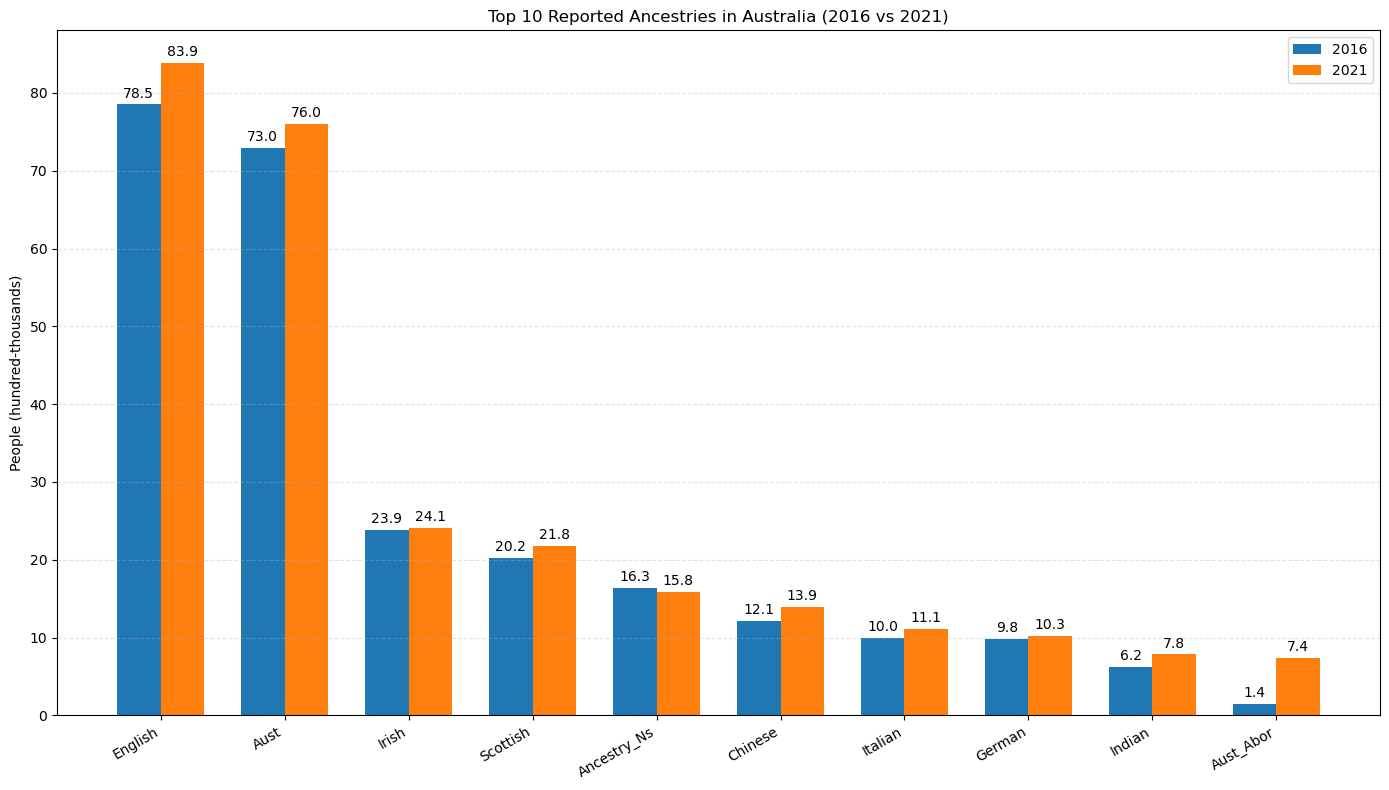

In [7]:
x = np.arange(len(top10_counts))
w = 0.35
y16 = (top10_counts["2016"] / 100_000).values
y21 = (top10_counts["2021"] / 100_000).values

plt.figure(figsize=(14, 8))
b16 = plt.bar(x - w/2, y16, width=w, label="2016")
b21 = plt.bar(x + w/2, y21, width=w, label="2021")

plt.xticks(x, top10_counts.index, rotation=30, ha="right")
plt.ylabel("People (hundred-thousands)")
plt.title("Top 10 Reported Ancestries in Australia (2016 vs 2021)")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.legend()

# annotate BOTH years (optional, looks better)
for bars in [b16, b21]:
    for rect in bars:
        h = rect.get_height()
        if h > 0:
            plt.text(rect.get_x() + rect.get_width()/2, h + 0.5, f"{h:.1f}",
                     ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


This bar chart shows the continued dominance of English and Australian ancestries, while groups like Indian, Chinese, and Aboriginal are growing.

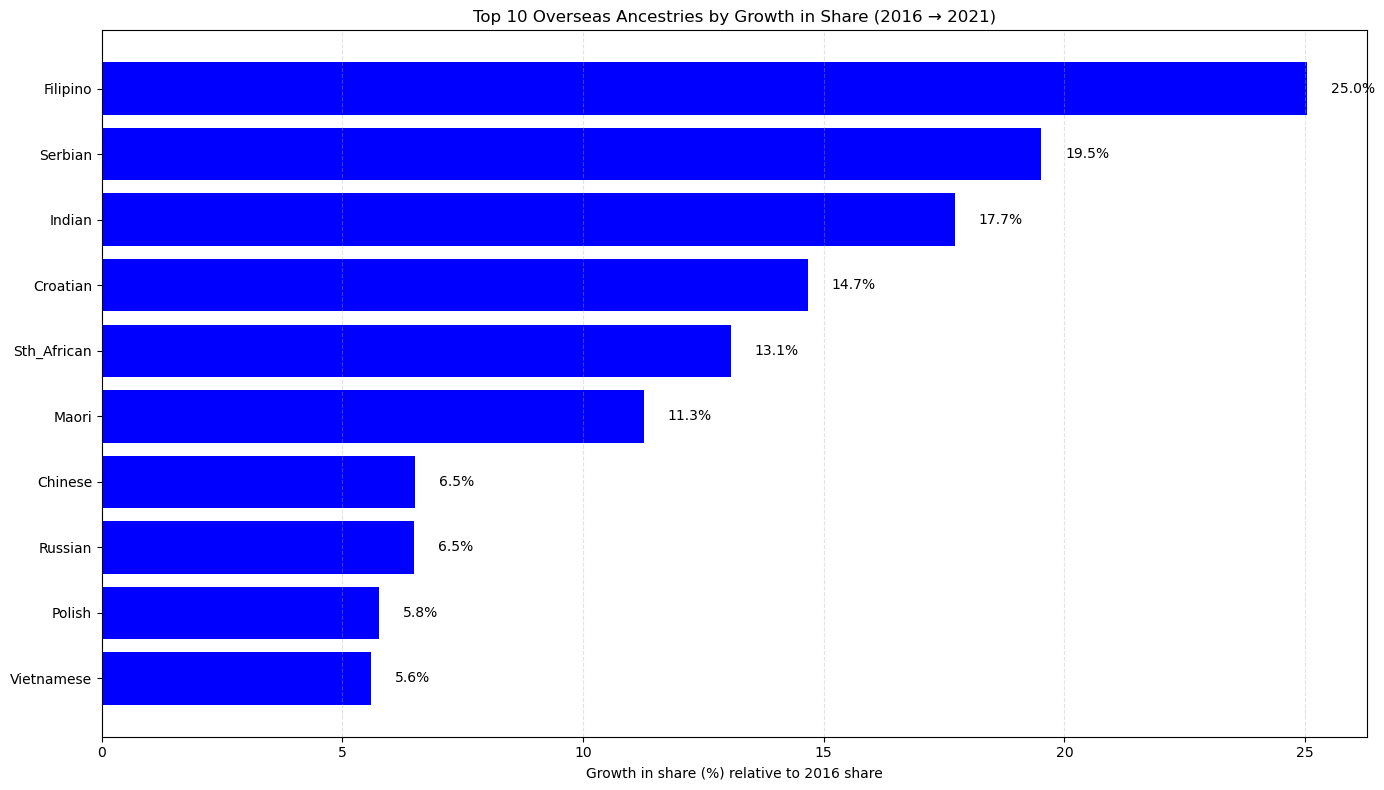

In [10]:
# --- Top 10 Overseas Ancestries by Growth in Share (2016 → 2021) ---


drop_exact = {"geo_code", "Australian", "Other", "Total", "Not Stated"}
# lowercase keywords that should not appear in an ancestry column name
drop_keywords = [
    "parents", "father", "mother",        # parental breakdowns
    "birthplace not stated", "not stated",
    "abor",                                # catches aust_abor and aboriginal
]

def overseas_cols_from(df):
    keep = []
    for c in df.columns:
        if c in drop_exact:
            continue
        cl = c.lower()
        if any(k in cl for k in drop_keywords):
            continue
        keep.append(c)
    return keep

# common ancestry columns present in both years after exclusions
overseas_cols = sorted(set(overseas_cols_from(df16)).intersection(overseas_cols_from(df21)))
assert len(overseas_cols) > 0, "No overseas ancestry columns found in both years."

# counts and totals
counts16 = df16.loc[0, overseas_cols].astype(float)
counts21 = df21.loc[0, overseas_cols].astype(float)
total16, total21 = counts16.sum(), counts21.sum()

# shares of the overseas total
pct16 = counts16 / total16 * 100.0
pct21 = counts21 / total21 * 100.0

# growth in share (relative to 2016 share)
growth = ((pct21 - pct16) / pct16.replace(0, np.nan)) * 100.0
table = pd.DataFrame({"2016%": pct16, "2021%": pct21, "growth%": growth})

# top 10 by growth
top10 = table.sort_values("growth%", ascending=False).head(10)

# plot
plt.figure(figsize=(14, 8))
bars = plt.barh(top10.index, top10["growth%"], color="blue")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.35)
plt.xlabel("Growth in share (%) relative to 2016 share")
plt.title("Top 10 Overseas Ancestries by Growth in Share (2016 → 2021)")

# labels on bars
for b in bars:
    v = b.get_width()
    plt.text(v + (0.5 if v >= 0 else -0.5), b.get_y() + b.get_height()/2,
             f"{v:.1f}%", va="center")

plt.tight_layout()
plt.show()


Highlights rapid increases in communities such as Filipino, Indian, and Serbian, reflecting recent migration trends.

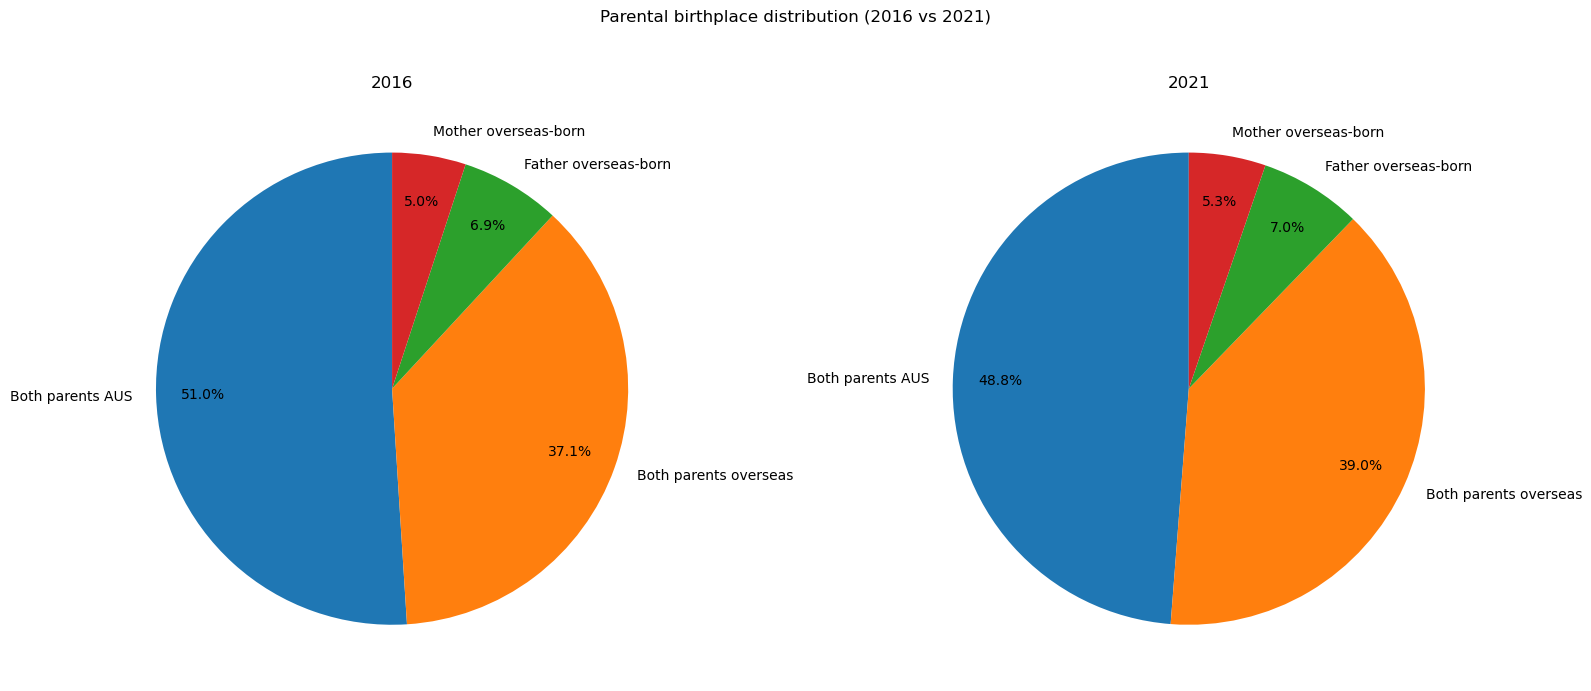

In [9]:
p2016 = parents["2016"] / parents["2016"].sum() * 100
p2021 = parents["2021"] / parents["2021"].sum() * 100

#  Nice labels for the pies (include % in labels)
labels = parents["Parental birthplace"].tolist()



fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle("Parental birthplace distribution (2016 vs 2021)")

# 2016 pie
axes[0].pie(
    p2016.values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.8
)
axes[0].axis("equal")
axes[0].set_title("2016")

# 2021 pie
axes[1].pie(
    p2021.values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.8
)
axes[1].axis("equal")
axes[1].set_title("2021")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Highlights rapid increases in communities such as Filipino, Indian, and Serbian, reflecting recent migration trends.

# Data Analysis

### Bar Chart - Top Reported Ancestries in Australia (2016 vs 2021)

- **Anglo-Celtic Dominance**: **English and Australian** remain to dominate ancestry records, with English at around **8.4 million** in 2021 and Australian at **7.6 million**. Together, they account for well more than half of all ancestry responses. This illustrates the continued influence of Anglo-Celtic heritage, which has long defined Australia's identity.

- **Rising Asian Communities**: **Indian and Chinese** ancestries are notable for their rapid expansion. Indian ancestry nearly doubled to **973,000**, while Chinese ancestry increased to approximately **1.4 million**. These trends emphasise the importance of recent migration and Australia's developing cultural linkages with Asia.

- **Growth in Aboriginal Identity**: **Aboriginal ancestry** grew dramatically, from over **648,000** in 2016 to more than **812,000**in 2021. This high surge is positive since it demonstrates both demographic growth and increased recognition of Indigenous identity, which is critical given the population's traditionally modest size in comparison to other groups.

- **Scottish and Irish ancestry** populations remain similar (around **2.1 million** and **2.5 million**, respectively). Their consistent presence demonstrates that long-established migrant communities remain a significant part of the population, even if they are not growing as quickly as younger groups.


Overall, the plot indicates that while English and Australian continue to be dominating ancestries, the increase of Asian groups and Indigenous identification signals a wider cultural change toward greater diversity.


### Growth in Overseas Ancestries (2016 vs 2021)

- **South and Southeast Asian communities**: **Filipino (+25.0%),Indian (+17.7%) and Chinese (+6.5%)** ancestries are all experiencing significant growth. This reflects Australia's demand for skilled migrants, as well as the role of overseas students, who frequently stay after graduation to contribute to the labour market. These groups are impacting Australia's demographic structure, since the country relies on migration to fuel economic and population growth.

- **Education and workforce demand**: International education is one of Australia's most important export industries, and the growing number of students from **Indian and Chinese** ancestry is directly related to this. Many students become long-term residents, which strengthens Australia's cultural and economic links to Asia.

- **European migration remains vital**: Despite the focus on Asia, European groups such as **Serbian (+19.5%) and Croatian (+14.7%)** witnessed significant gains, demonstrating that earlier migration links continue to impact Australia's ethnic mix.

- **Regional and trans-Tasman ties**: **South African (+13.1%) and Māori (+11.3%)** developments indicate ongoing migration from surrounding regions. Māori increase is a result of long-term migration from New Zealand, which contributes to cross-border integration.

- **Broader cultural shifts**: Mild but consistent increases in ancestries such as **Russian (+6.5%), Polish (+5.8%), and Vietnamese (+5.6%)** highlight Australia's continuing population diversification. Migration is not restricted to a single region, but extends across Europe, Asia, and the Pacific.

The rising percentage of Asian and Pacific ancestry indicates how migration is influencing modern Australia. It emphasises the country's openness to global talent, reliance on immigration for economic progress, and the ongoing expansion of its cultural variety.

### Parental Birthplace Distribution (2016 vs 2021)

- **Decline in both parents born in Australia**: The percentage of people whose parents were both born in Australia fell from **51.0%** in 2016 to **48.8%** in 2021. This drop demonstrates how overseas-born groups are increasingly influencing Australia's demographics.

- **Increase in People With Both Parents Born Overseas**: The number of people born overseas increased from **37.1%** in 2016 to **39.0%** in 2021. This trend illustrates Australia's continued migration-driven expansion and supports the idea that newer generations are strongly connected to migrant ancestry.

- **Stable Mixed Parentage (One Overseas Parent)** - Categories with only the mother **(5.0% → 5.3%)** or father **(6.9% → 7.0%)** born overseas show relatively minor gains. This shows that mixed-parentage homes are rather steady, and that intermarriage between Australian-born and foreign-born parents is not rapidly growing.

The transition from "both parents Australian-born" to "both parents overseas-born" is a clear reflection of Australia's changing demographic structure. This pattern highlights how migration has become important to the nation's cultural identity.

### Combined Insights
When viewed together, the three graphs clearly support the research question: How have ancestry patterns in Australia evolved between 2016 and 2021, and what does this tell us about the significance of migration in fostering cultural diversity? The results demonstrate that, while long-established ancestries like English and Australian continue to dominate, newer migrant groups are rapidly expanding, and Indigenous identity is also increasing. At the same time, the shift in parental birthplace distributions demonstrates how migration is influencing not only the first generation but also family patterns throughout the country.

These trends demonstrate that migration has played a significant role in reshaping Australia's cultural identity. Rather than just strengthening previous Anglo-Celtic roots, Census data indicates a more diversified population, with overseas ancestry and mixed parental origins becoming more prominent. This illustrates that migration is more than just individual arrivals; it is fundamentally changing the national fabric and cultural variety of modern Australia.


